In [18]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
import pickle

In [2]:
data_raw = pd.read_csv('pitches.csv')

In [4]:
# Print out size, shape, and column names
print("size: " + str(data_raw.size))
print("shape: " + str(data_raw.shape))
print("columns: " + str(data_raw.columns))

size: 114686160
shape: (2867154, 40)
columns: Index(['px', 'pz', 'start_speed', 'end_speed', 'spin_rate', 'spin_dir',
       'break_angle', 'break_length', 'break_y', 'ax', 'ay', 'az', 'sz_bot',
       'sz_top', 'type_confidence', 'vx0', 'vy0', 'vz0', 'x', 'x0', 'y', 'y0',
       'z0', 'pfx_x', 'pfx_z', 'nasty', 'zone', 'code', 'type', 'pitch_type',
       'event_num', 'b_score', 'ab_id', 'b_count', 's_count', 'outs',
       'pitch_num', 'on_1b', 'on_2b', 'on_3b'],
      dtype='object')


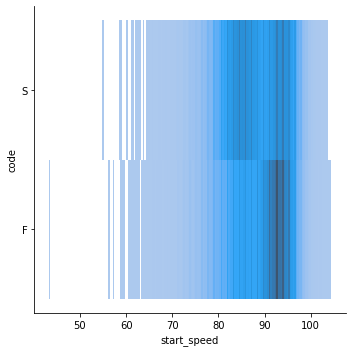

In [3]:
test = data_raw
test = test[test.code.isin(['S', 'F'])]
test = test[test.s_count == 2]
# balance out the cases
tstrikes = test[test.code == 'S']
tfouls = test[test.code == 'F'][0:len(tstrikes)]
tjoin = [tstrikes, tfouls]
test = pd.concat(tjoin)
sns.displot(data = test, x = 'start_speed', y = 'code')

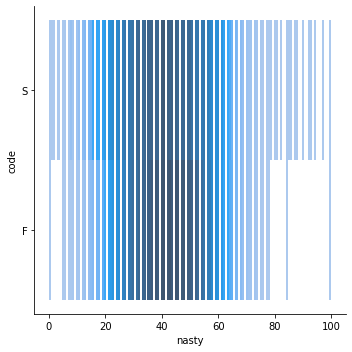

In [4]:
sns.displot(data = test, x="nasty", y="code")

In [3]:
df = data_raw
# drop everything except swinging strikes and foul balls
df = df[df.code.isin(['S', 'F'])]
# only 2-strike counts
df = df[df.s_count == 2]
# dropping useless columns and rows with null values
df = df.drop(["zone", "type_confidence", "pitch_type", "ab_id", "event_num"], axis = 1)
df = df.drop(["y0", "type", "b_score", "outs", "pitch_num", "b_count", "s_count", "on_1b", "on_2b", "on_3b"], axis = 1)
df = df.dropna()
print(df.shape)

(283316, 25)


In [19]:
print(df.shape)
df.columns

(283316, 25)


Index(['px', 'pz', 'start_speed', 'end_speed', 'spin_rate', 'spin_dir',
       'break_angle', 'break_length', 'break_y', 'ax', 'ay', 'az', 'sz_bot',
       'sz_top', 'vx0', 'vy0', 'vz0', 'x', 'x0', 'y', 'z0', 'pfx_x', 'pfx_z',
       'nasty', 'code'],
      dtype='object')

In [4]:
# balance out the cases
strikes = df[df.code == 'S']
fouls = df[df.code == 'F']
fouls = fouls[0:len(strikes)]
tojoin = [strikes, fouls]
df = pd.concat(tojoin)
print(strikes.shape)
df.shape

(92995, 25)


(185990, 25)

In [5]:
import sklearn.model_selection as tts
features_train, features_test, labels_train, labels_test = tts.train_test_split(df.transpose()[:24].transpose(), df.code, test_size = 0.3, random_state = 69)

In [29]:
print(features_train.shape)
print(features_test.shape)
print(labels_train.shape)
print(labels_test.shape)

(130193, 24)
(55797, 24)
(130193,)
(55797,)


In [6]:
# IMPORTANT: DO NOT TOUCH VAL UNTIL VALIDATION PHASE!!
features_test, features_val, labels_test, labels_val = tts.train_test_split(features_test, labels_test, test_size = 0.3, random_state = 420)

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(features_train)
features_train_scaled = scaler.transform(features_train)
features_test_scaled = scaler.transform(features_test)
features_val_scaled = scaler.transform(features_val)

In [11]:
mlp = MLPClassifier(random_state=1, max_iter=2000).fit(features_train_scaled, labels_train)

In [14]:
mlp.score(features_test_scaled, labels_test)

0.782113321555675

In [24]:
rf = RandomForestClassifier()
rf.fit(features_train, labels_train)
rf.score(features_test, labels_test)

0.7167729216273652

In [17]:
rf_scaled = RandomForestClassifier().fit(features_train_scaled, labels_train)
rf_scaled.score(features_test_scaled, labels_test)

0.7186163811864711

In [25]:
gb = GradientBoostingClassifier(loss='exponential', n_estimators = 1000)
gb.fit(features_train, labels_train)
gb.score(features_test, labels_test)

0.7807307268863456

In [19]:
gb_scaled = GradientBoostingClassifier(loss='exponential', n_estimators = 1000)
gb_scaled.fit(features_train_scaled, labels_train)
gb_scaled.score(features_test_scaled, labels_test)

0.780705123281358

In [26]:
ab = AdaBoostClassifier(n_estimators=1000)
ab.fit(features_train, labels_train)
ab.score(features_test, labels_test)

0.7544358245640986

In [20]:
ab_scaled = AdaBoostClassifier(n_estimators=1000)
ab_scaled.fit(features_train_scaled, labels_train)
ab_scaled.score(features_test_scaled, labels_test)

0.7544358245640986

In [31]:
evc = VotingClassifier(estimators=[('gb', gb), ('ab', ab)], voting = 'hard')
evc.fit(features_train, labels_train)
evc.score(features_test, labels_test)

0.7698491947666232

In [22]:
evc_scaled = VotingClassifier(estimators=[('gbs', gb_scaled), ('abs', ab_scaled), ('rfs', rf_scaled), ('mlps', mlp)], voting = 'hard')
evc_scaled.fit(features_train_scaled, labels_train)
evc_scaled.score(features_test_scaled, labels_test)

0.7745858616893259

In [27]:
with open("mlp.pkl", "wb") as mlpw:
    pickle.dump(mlp, mlpw)
with open("ab.pkl", "wb") as abw:
    pickle.dump(ab, abw)
with open("gb.pkl", "wb") as gbw:
    pickle.dump(gb, gbw)
with open("rf.pkl", "wb") as rfw:
    pickle.dump(rf, rfw)
with open("evc.pkl", "wb") as evcw:
    pickle.dump(evc_scaled, evcw)

In [8]:
gb = pickle.load(gbc)
gb.score(features_test, labels_test)

NameError: name 'gbc' is not defined